# Traveling Salesman Problem

## ***Étape 1:*** Lecture du fichier .txt et initialisation de notre métrique

In [92]:
def import_fichier(path):
    """
    :param path: chemin du fichier txt à lire
    :return num_villes : nombre de villes
            villes : vecteur de coordonnées des villes
            distances : matrice des distances entre deux villes
    """
    try:
        with open(path, "r") as fichier:
            lignes = fichier.readlines()

    except FileNotFoundError:
        print(f"Le fichier {path} n'a pas été trouvé.")
    except Exception as e:
        print(f"Une erreur s'est produite : {str(e)}")

    # Création de la liste des coordonnées (x, y) des villes
    villes = []
    for i in range(1, len(lignes)):
        elements = lignes[i].split()
        if len(elements) >= 2:
            x, y = int(elements[0]), int(elements[1])
            villes.append([x, y])
    return villes

In [93]:
import math

def calcul_distance(ville1, ville2):
    """
    :param ville1:
    :param ville2:
    :return: distance euclidienne entre deux villes
    """
    x1, y1 = ville1
    x2, y2 = ville2
    return math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

## ***Étape 2:*** Réalisation de notre clustering

* Dans notre travail, nous réalisions une approche clustering. En effet nous avons implémenté plusieurs approches qui fonctionnaient plutôt bien pour un nombre de villes raisonnables. Cependant lorsque le nombre de villes dépassait un certain seuil, le temps de calcul explosait ce qui nous empêchait de sortir des résultats cohérents en moins d'une minute.
* Ainsi, notre démarche a été d'obtenir des groupes de villes assez proches avec du clusturing. Ensuite, nous cherchons localement à optimiser pour chaque cluster un chemin. Puis de relier les chemins afin d'obtenir un chemin global.

In [94]:
from sklearn.cluster import KMeans

def clusturing(K, donne):
    """
    :param K: nombre de clusters
    : param donne : donne des villes à clusturer
    :return:
    centroids : centre des clusters
    labels : appartenance aux groupes
    groupe : liste de groupe des points clusturés
    """

    kmeans = KMeans(n_clusters=K)
    # Effectuer le clustering sur les données
    kmeans.fit(donne)
    # Obtenir les centres de cluster
    centroids = kmeans.cluster_centers_
    # Obtenir les étiquettes de cluster pour chaque point
    labels = kmeans.labels_

    groupe = [[] for i in range(K)]
    for i in range(len(labels)):
        L = labels[i]
        groupe[L].append(donne[i])

    return centroids, labels, groupe

## ***Étape 3:*** Relier les clusters entre eux

* L'étape 2 nous donne une liste de tous les centres des clusters. Ainsi, cherchons à optimiser la distance entre les clusters. 
* Puis nous cherchons parmi les clusters qui sont liés : quels sont les points les plus proches.
* Ce choix est discutable car même si deux centres de cluster sont les plus proches, un point d'un autre cluster peut etre plus proche d'un point d'un cluster 

### Pour trouver la plus courte distance, on utilise effectue une recherche heuristique (glouton + descente de swap)

In [95]:
import numpy as np

def plusproche_voisin(donne, depart, point_restant):
    """
    :param donne: vecteurs des coordonnées des villes
    :param depart: point de recherche
    :param point_restant: indices des villes pas encore visitées
    :return: la distance entre les deux points,indice du plus proche voisin
    """
    min = 10000
    for i in range(len(donne)):
        if i != depart and i in point_restant:
            dist = calcul_distance(donne[depart], donne[i])
            if dist < min:
                min = dist
                indice = i

    return min, indice

def permutation(config, i, j):
    """
    :param config: la liste a permuter
    :param i: indice de permutation
    :param j: indice de permutation
    :return: la liste premuté
    """

    config_inter = config.copy()
    config_inter[i] = config[j]
    config_inter[j] = config[i]
    return config_inter

def glouton(donne):
    depart = int(np.random.rand() * len(donne) // 1)
    # calcul plus proche voisin
    prems = depart
    liste_entiers = list(range(1000))
    liste_entiers.remove(depart)
    compt = 0
    config = [donne[depart]]
    while compt < len(donne) - 1:
        min, indice = plusproche_voisin(donne, depart, liste_entiers)

        compt += 1
        liste_entiers.remove(indice)
        depart = indice
        config.append(donne[indice])
    dist_verif = [calcul_distance(config[i], config[i + 1]) for i in range(len(config) - 1)]
    distance = sum(dist_verif)
    return config, distance

def swap_descente_complete(solution, distance):
    compt = 0
    while compt < len(solution):
        for i in range(len(solution)):
            if i != compt:
                # permutation
                config_tempo = permutation(solution, compt, i)
                nouvelle_distance = 0
                for i in range(len(config_tempo) - 1):
                    nouvelle_distance += calcul_distance(
                        config_tempo[i], config_tempo[i + 1]
                    )
                nouvelle_distance += calcul_distance(
                    config_tempo[len(config_tempo) - 1], config_tempo[0]
                )
                # Si la solution est la bonne
                if nouvelle_distance < distance:
                    compt = 0
                    solution = config_tempo
                    distance = nouvelle_distance
                    break
        compt += 1
    return distance, solution

In [96]:
def organisation_groupes(centroids, groupe):
    """
    :param centroids: liste des centres des clusters
    :param groupe: liste des groupes de coordonné
    :return: liste des groupes ordonnés
    """
    point_le_plus_a_gauche = min(centroids.tolist(), key=lambda point: point[0])
    indice_point_gauche = (centroids.tolist()).index(point_le_plus_a_gauche)
    range_L = list(range(len(centroids)))
    range_L.remove(indice_point_gauche)
    dist,autre_cluster = plusproche_voisin(centroids.tolist(),indice_point_gauche,range_L)

    sol_opti, min_D = glouton_depart_arrive(centroids,indice_point_gauche,autre_cluster)
    end_distance, end_solution = swap_descente_complete(sol_opti, min_D)
    for _ in range(5):
        end_distance, end_solution = swap_forced_deg3(end_solution, end_distance, None)
    groupe_ordonne = [0] * len(groupe)
    end_sol_temp = [list(arr) for arr in end_solution]
    for i in range(len(end_sol_temp)):
        centre = centroids[i]
        for indice, sous_liste in enumerate(end_sol_temp):
            if (sous_liste == centre)[0] and (sous_liste == centre)[1]:
                index = indice
        groupe_ordonne[index] = groupe[i]

    return groupe_ordonne

## ***Étape 4:*** Recherche des points de liaisons

* On connaît les clusters qui doivent être reliés : on cherche les points les plus proches entre toutes les liaisons.
* Dans la fonction Depart_arrive, on utilise une variable globale Liste_point_banni afin d'interdire qu'un point soit un départ et un arrivée.

In [97]:
def Depart_arrive(grp_av, groupe_apr):
    global Liste_point_bani
    """
    :param grp_av: groupe 1
    :param groupe_apr: groupe 2
    :return: deux points els proches de chaque groupe
    """
    distance_min = float('inf')
    point1_plus_proche = None
    point2_plus_proche = None
    for point1 in grp_av:
        if point1 in Liste_point_bani:
            continue
        for point2 in groupe_apr:
            if point2 in Liste_point_bani:
                continue
            dist = calcul_distance(point1, point2)
            if dist < distance_min:
                distance_min = dist

                point1_plus_proche = point1
                point2_plus_proche = point2
    Liste_point_bani.append(point1_plus_proche)
    Liste_point_bani.append(point2_plus_proche)
    return [point1_plus_proche, point2_plus_proche]

In [98]:
def liste_depart_arrive(groupe):
    """
    :param groupe: groupes des points ordonnée
    :return: liste des points a connecté entre groupes
    """
    liste_depart_arrive = []
    for i in range(len(groupe) - 1):
        liste_inter = Depart_arrive(groupe[i], groupe[i + 1])
        liste_depart_arrive.append(liste_inter)
    liste_depart_arrive.append(Depart_arrive(groupe[len(groupe) - 1], groupe[0]))

    return liste_depart_arrive

## ***Étape 5:*** Optimisation aux seins des clusters

* L'étape 3 nous donne les points de départ/arrivée c'est-à-dire que l'on sait on doit commencer et terminer notre chemin.
* Pour optimiser ce chemin, on utilise la aussi une méthode glouton et swap mais cette fois-ci en imposant les points d'arrivée/départ.
* Le glouton nous donne une solution et on utilise ensuite une combinaison de swaps à différents degrés pour optimiser la distance à l'aide des fonctions ***swap_premier_dernier, swap_force_max, swap_forced_deg3***.


In [99]:
def cherche_point(liste, point):
    """
    :param liste:
    :param point:
    :return: trouve l'indice du point dans la liste
    """
    index_trouve = None
    for index, element in enumerate(liste):
        if element == point:
            index_trouve = index
            break
    return index_trouve

In [100]:
def glouton_depart_arrive(donne, depart, arrive):
    """
    :param donne: vecteurs des villes
    :param depart: point de depart du glouton
    :param arrive: point d'arrivé du glouton
    :return: la solution, la distance totale
    """

    liste_entiers = list(range(len(donne)))
    liste_entiers.remove(depart)
    liste_entiers.remove(arrive)
    compt = 0
    config = [donne[depart]]
    while compt < len(donne) - 2:
        _, indice = plusproche_voisin(donne, depart, liste_entiers)
        compt += 1
        liste_entiers.remove(indice)
        depart = indice
        config.append(donne[indice])
    config.append(donne[arrive])
    distance_totale = [
        calcul_distance(config[i], config[i + 1]) for i in range(len(config) - 1)
    ]
    return config, sum(distance_totale)

def swap_premier_dernier(solution, distance):
    """
    :param solution: vecteur de données
    :param distance: distance total de la solution
    :return: solution & distance total de la solution
    """
    compt = 1
    swap_reussi = False
    while compt < len(solution) - 1:
        for i in range(compt, len(solution) - 1):
            if i != compt:
                # on enleve la distance des anciens
                dist1_av = calcul_distance(solution[compt], solution[compt + 1])
                dist3_av = calcul_distance(solution[i], solution[i + 1])
                dist2_av = calcul_distance(solution[compt], solution[compt - 1])
                dist4_av = calcul_distance(solution[i], solution[i - 1])

                somme_des_dists_1 = dist1_av + dist2_av + dist3_av + dist4_av

                # permutation
                config_tempo = permutation(solution, compt, i)

                # ajout des nouvelles
                dist1 = calcul_distance(config_tempo[compt], config_tempo[compt + 1])
                dist3 = calcul_distance(config_tempo[i], config_tempo[i + 1])
                dist2 = calcul_distance(config_tempo[compt], config_tempo[compt - 1])
                dist4 = calcul_distance(config_tempo[i], config_tempo[i - 1])

                somme_des_dists_2 = dist1 + dist2 + dist3 + dist4

                nouvelle_distance = distance - somme_des_dists_1 + somme_des_dists_2

                # Si la solution est la bonne
                if nouvelle_distance < distance:
                    solution = config_tempo
                    distance = nouvelle_distance
                    swap_reussi = True
                    compt = 1

        compt += 1
        if compt == (len(solution) - 1) and not swap_reussi:
            ran = (np.random.rand(2) * (len(solution) - 3) // 1) + 1

            x = int(ran[0])
            y = int(ran[1])
            dist1_av = calcul_distance(solution[x], solution[x + 1])
            dist3_av = calcul_distance(solution[y], solution[y + 1])
            dist2_av = calcul_distance(solution[x], solution[x - 1])
            dist4_av = calcul_distance(solution[y], solution[y - 1])

            somme_des_dists_1 = dist1_av + dist2_av + dist3_av + dist4_av

            solution = permutation(solution, x, y)

            # ajout des nouvelles
            dist1 = calcul_distance(solution[x], solution[x + 1])
            dist3 = calcul_distance(solution[y], solution[y + 1])
            dist2 = calcul_distance(solution[x], solution[x - 1])
            dist4 = calcul_distance(solution[y], solution[y - 1])

            somme_des_dists_2 = dist1 + dist2 + dist3 + dist4

            distance = distance - somme_des_dists_1 + somme_des_dists_2

            swap_reussi = True
            compt = 1

    dist_verif = [
        calcul_distance(solution[i], solution[i + 1]) for i in range(len(solution) - 1)
    ]

    return sum(dist_verif), solution

def swap_premier_dernier(solution, distance):
    """
    :param solution: vecteur de donnés
    :param distance: distance total de la solution
    :return: solution & distance total de la solution
    """
    compt = 1
    swap_reussi = False
    while compt < len(solution) - 1:
        for i in range(1, len(solution) - 1):
            if i != compt:
                # on enleve la distance des anciens
                dist1_av = calcul_distance(solution[compt], solution[compt + 1])
                dist3_av = calcul_distance(solution[i], solution[i + 1])
                dist2_av = calcul_distance(solution[compt], solution[compt - 1])
                dist4_av = calcul_distance(solution[i], solution[i - 1])

                somme_des_dists_1 = dist1_av + dist2_av + dist3_av + dist4_av

                # permutation
                config_tempo = permutation(solution, compt, i)

                # ajout des nouvelles
                dist1 = calcul_distance(config_tempo[compt], config_tempo[compt + 1])
                dist3 = calcul_distance(config_tempo[i], config_tempo[i + 1])
                dist2 = calcul_distance(config_tempo[compt], config_tempo[compt - 1])
                dist4 = calcul_distance(config_tempo[i], config_tempo[i - 1])

                somme_des_dists_2 = dist1 + dist2 + dist3 + dist4

                nouvelle_distance = distance - somme_des_dists_1 + somme_des_dists_2

                # Si la solution est la bonne
                if nouvelle_distance < distance:
                    solution = config_tempo
                    distance = nouvelle_distance
                    swap_reussi = True
                    compt = 1

        compt += 1
        if compt == (len(solution) - 1) and not swap_reussi:
            ran = (np.random.rand(2) * (len(solution) - 3) // 1) + 1

            x = int(ran[0])
            y = int(ran[1])
            dist1_av = calcul_distance(solution[x], solution[x + 1])
            dist3_av = calcul_distance(solution[y], solution[y + 1])
            dist2_av = calcul_distance(solution[x], solution[x - 1])
            dist4_av = calcul_distance(solution[y], solution[y - 1])

            somme_des_dists_1 = dist1_av + dist2_av + dist3_av + dist4_av

            solution = permutation(solution, x, y)

            # ajout des nouvelles
            dist1 = calcul_distance(solution[x], solution[x + 1])
            dist3 = calcul_distance(solution[y], solution[y + 1])
            dist2 = calcul_distance(solution[x], solution[x - 1])
            dist4 = calcul_distance(solution[y], solution[y - 1])

            somme_des_dists_2 = dist1 + dist2 + dist3 + dist4

            distance = distance - somme_des_dists_1 + somme_des_dists_2

            swap_reussi = True
            compt = 1

    dist_verif = [
        calcul_distance(solution[i], solution[i + 1]) for i in range(len(solution) - 1)
    ]
    return sum(dist_verif), solution

def swap_force_max(solution, distance, indice_max):
    """
    :param solution:
    :param distance:
    :param indice_max:
    :return:
    """
    swap_reussi = False
    compteur = 0
    while not swap_reussi and compteur < len(solution):
        i = np.random.rand(1) * (len(solution) - 3) // 1 + 1
        if int(i[0]) == 0:
            i = [1]
        i = int(i[0])
        dist1_av = calcul_distance(solution[indice_max], solution[indice_max + 1])
        dist3_av = calcul_distance(solution[i], solution[i + 1])
        dist2_av = calcul_distance(solution[indice_max], solution[indice_max - 1])
        dist4_av = calcul_distance(solution[i], solution[i - 1])

        somme_des_dists_1 = dist1_av + dist2_av + dist3_av + dist4_av

        # permutation
        config_tempo = permutation(solution, indice_max, i)

        dist1 = calcul_distance(config_tempo[indice_max], config_tempo[indice_max + 1])
        dist3 = calcul_distance(config_tempo[i], config_tempo[i + 1])
        dist2 = calcul_distance(config_tempo[indice_max], config_tempo[indice_max - 1])
        dist4 = calcul_distance(config_tempo[i], config_tempo[i - 1])

        somme_des_dists_2 = dist1 + dist2 + dist3 + dist4

        nouvelle_distance = distance - somme_des_dists_1 + somme_des_dists_2

        distance_swap, sol_swap = swap_premier_dernier(config_tempo, nouvelle_distance)

        if distance_swap < distance:
            distance = distance_swap
            swap_reussi = True
            solution = sol_swap
        compteur += 1

    dist_verif = [
        calcul_distance(solution[i], solution[i + 1]) for i in range(len(solution) - 1)
    ]
    sum_dist = sum(dist_verif)

    return sum_dist, solution


def swap_forced_deg3(solution, distance, indice_max):
    swap_reussi = False
    compteur = 0
    indice_max = np.random.rand(1) * (len(solution) - 3) // 1 + 1
    if int(indice_max[0]) == 0:
        indice_max = [1]
    indice_max = int(indice_max[0])
    while not swap_reussi and compteur < len(solution):
        i = np.random.rand(1) * (len(solution) - 3) // 1 + 1
        if int(i[0]) == 0:
            i = [1]
        i = int(i[0])
        dist1_av = calcul_distance(solution[indice_max], solution[indice_max + 1])
        dist3_av = calcul_distance(solution[i], solution[i + 1])
        dist2_av = calcul_distance(solution[indice_max], solution[indice_max - 1])
        dist4_av = calcul_distance(solution[i], solution[i - 1])

        somme_des_dists_1 = dist1_av + dist2_av + dist3_av + dist4_av

        # permutation
        config_tempo = permutation(solution, indice_max, i)

        dist1 = calcul_distance(config_tempo[indice_max], config_tempo[indice_max + 1])
        dist3 = calcul_distance(config_tempo[i], config_tempo[i + 1])
        dist2 = calcul_distance(config_tempo[indice_max], config_tempo[indice_max - 1])
        dist4 = calcul_distance(config_tempo[i], config_tempo[i - 1])

        somme_des_dists_2 = dist1 + dist2 + dist3 + dist4

        nouvelle_distance = distance - somme_des_dists_1 + somme_des_dists_2

        # deg 2
        while True:
            i = np.random.rand(1) * (len(config_tempo) - 3) // 1 + 1
            if int(i[0]) == 0:
                i = [1]
            i = int(i[0])

            j = np.random.rand(1) * (len(config_tempo) - 3) // 1 + 1
            if int(j[0]) == 0:
                j = [1]
            j = int(j[0])

            if i != j:
                break

        dist1_av = calcul_distance(solution[j], solution[j + 1])
        dist3_av = calcul_distance(solution[i], solution[i + 1])
        dist2_av = calcul_distance(solution[j], solution[j - 1])
        dist4_av = calcul_distance(solution[i], solution[i - 1])

        somme_des_dists_1 = dist1_av + dist2_av + dist3_av + dist4_av

        config_tempo = permutation(config_tempo, j, i)

        dist1 = calcul_distance(config_tempo[j], config_tempo[j + 1])
        dist3 = calcul_distance(config_tempo[i], config_tempo[i + 1])
        dist2 = calcul_distance(config_tempo[j], config_tempo[j - 1])
        dist4 = calcul_distance(config_tempo[i], config_tempo[i - 1])

        somme_des_dists_2 = dist1 + dist2 + dist3 + dist4

        nouvelle_distance = nouvelle_distance - somme_des_dists_1 + somme_des_dists_2

        distance_swap, sol_swap = swap_premier_dernier(config_tempo, nouvelle_distance)

        if distance_swap < distance:
            distance = distance_swap
            swap_reussi = True
            solution = sol_swap
        compteur += 1

    dist_verif = [
        calcul_distance(solution[i], solution[i + 1]) for i in range(len(solution) - 1)
    ]
    sum_dist = sum(dist_verif)

    return sum_dist, solution


* Déclaration des constantes de notre algorithme

In [116]:
# forced max swap parameters
FORCED_MAX_SWAP_PRECISION = 0.5
FORCED_MAX_SWAP_TRY = 50

In [114]:
def optimisation_des_groupes(groupe_ordonne, liste_depart_arriv):
    """
    :param groupe_ordonne: groupe ordonnés
    :param liste_depart_arriv: points a relier entre groupes
    :return: liste ordonnées des points a parcourir
    """
    Sol_gp = []
    liste_sol = []
    dist_total = 0
    for i in range(len(groupe_ordonne)):
        depart = liste_depart_arriv[i - 1][1]

        arrive = liste_depart_arriv[i][0]
        depart = cherche_point(groupe_ordonne[i], depart)
        arrive = cherche_point(groupe_ordonne[i], arrive)
        sol_gp1, dist_gp1 = glouton_depart_arrive(groupe_ordonne[i], depart, arrive)

        end_distance_gp1, end_solution_gp1 = swap_premier_dernier(sol_gp1, dist_gp1)

        distances = [
            calcul_distance(end_solution_gp1[i], end_solution_gp1[i + 1])
            for i in range(len(end_solution_gp1) - 1)
        ]

        index_max = distances.index(max(distances))
        if index_max == 0:
            index_max = 1
        if index_max == len(distances) - 1:
            index_max = index_max - 2

        compt = 0
        while (
            distances[index_max]
            > (FORCED_MAX_SWAP_PRECISION * sum(distances) / len(distances))
            and compt < FORCED_MAX_SWAP_TRY
        ):
            previous_dist = end_distance_gp1

            end_distance_gp1, end_solution_gp1 = swap_forced_deg3(
                end_solution_gp1, end_distance_gp1, index_max
            )
            distances = [
                calcul_distance(end_solution_gp1[i], end_solution_gp1[i + 1])
                for i in range(len(end_solution_gp1) - 1)
            ]

            index_max = distances.index(max(distances))
            if index_max == 0:
                index_max = 1
            if index_max == len(distances) - 1:
                index_max = index_max - 2

            # Si le swap deg 3 fonctionne on optimise le max
            if previous_dist > end_distance_gp1:
                end_distance_gp1, end_solution_gp1 = swap_force_max(
                    end_solution_gp1, end_distance_gp1, index_max
                )
                distances = [
                    calcul_distance(end_solution_gp1[i], end_solution_gp1[i + 1])
                    for i in range(len(end_solution_gp1) - 1)
                ]
                index_max = distances.index(max(distances))

                if index_max == 0:
                    index_max = 1
                if index_max == len(distances) - 1:
                    index_max = index_max - 2

            compt = compt + 1
        liste_sol.append(end_solution_gp1)
        dist_total += end_distance_gp1
        Sol_gp = Sol_gp + end_solution_gp1
    return Sol_gp, dist_total, liste_sol

## ***Étape 6:*** Implémentation du solver

In [103]:
import time

def solver(path):
    global Liste_point_bani
    best_cluster_score = float('inf')
    best_cluster = 0
    best_chemin = []
    best_groupe=[]
    data = import_fichier(path)
    debut_temps = time.time()    


    #k est le nombre de cluster : on fait varier le pas selon la taille du .txt
    if(len(data)<250):
        MIN_CLUSTER_RANGE = 10
        MAX_CLUSTER_RANGE = 11
    elif(len(data)<550):
        MIN_CLUSTER_RANGE = 30
        MAX_CLUSTER_RANGE = 31
    elif(len(data)<850):
        MIN_CLUSTER_RANGE = 60
        MAX_CLUSTER_RANGE = 61  
    else:
        MIN_CLUSTER_RANGE = 80
        MAX_CLUSTER_RANGE = 81
    for k in range(MIN_CLUSTER_RANGE, MAX_CLUSTER_RANGE):
        Liste_point_bani = []
        centroids, labels, groupe = clusturing(k, data)
        groupe_ordonne = organisation_groupes(centroids, groupe)
        liste_depart = liste_depart_arrive(groupe_ordonne)
        try:
            sol, distance, liste_sol = optimisation_des_groupes(groupe_ordonne, liste_depart)
            Liste_point_bani = []
            if distance < best_cluster_score:
                best_cluster_score = distance
                best_cluster = k
                best_chemin = sol
                best_groupe = groupe_ordonne
            print("resultat pour", k, "clusters : ", distance)
        except Exception as e :
            print(e)
            continue
    fin_temps = time.time()
    temps = fin_temps - debut_temps
    return best_cluster_score, best_cluster, best_chemin, best_groupe, temps

## ***Étape 7:*** Affichage des résulats

* Pour afficher graphiquement, on fait afficher en couleurs les clusters ensembles et on relie avec le chemin le plus optimal trouvé
* Pour les essais et mieux visualiser, on n'a pas relié le dernier et le premier cluster.

In [122]:
import matplotlib.pyplot as plt

def plot_chemin(chemin, groupe):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'purple', 'orange', 'lime']
    # On trace les points des groupes :
    for i in range(len(groupe)):
        x_i, y_i = zip(*groupe[i])
        plt.scatter(x_i, y_i, marker='o', label=f'Groupe {i}',  c=colors[i % len(colors)])
    # Trace les lignes reliant les points successivement
    x, y = zip(*chemin)
    for i in range(len(chemin) - 1):
        plt.plot([x[i], x[i + 1]], [y[i], y[i + 1]], linestyle='-', linewidth=2, color='blue')
    plt.xlabel('Coordonnée x')
    plt.ylabel('Coordonnée y')
    plt.show()

In [105]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

## ***Exemple:*** Exploitation des 5 fichiers .txt

resultat pour 10 clusters :  240.2368049778164
Pour Pb1.txt - Meilleur score : 240.2368049778164 avec K= 10


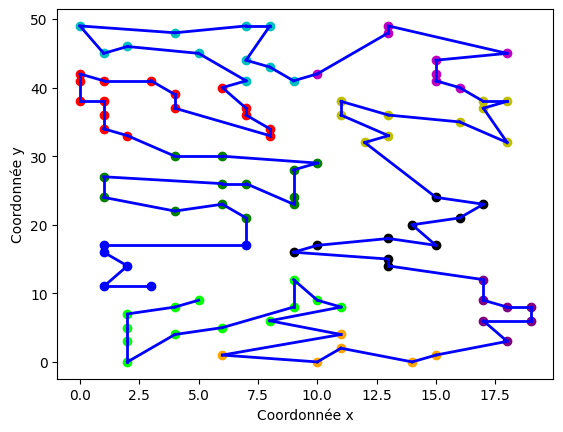

In [120]:
score1, k1, chemin1, groupe, temps1 = solver('./Pb1.txt')
print('Pour Pb1.txt - Meilleur score :', score1, 'avec K=', k1)
plot_chemin(chemin1, groupe)

resultat pour 10 clusters :  363.8849448963845
Pour Pb2.txt - Meilleur score : 363.8849448963845 avec K= 10


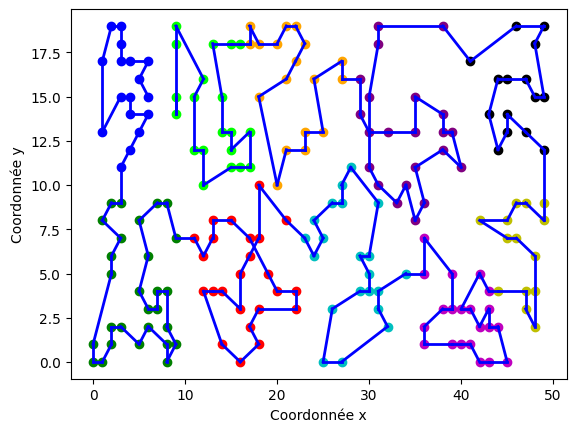

In [121]:
score2, k2, chemin2, groupe, temps2 = solver('./Pb2.txt')
print('Pour Pb2.txt - Meilleur score :', score2, 'avec K=', k2)
plot_chemin(chemin2, groupe)

resultat pour 30 clusters :  1564.055181417913
Pour Pb3.txt - Meilleur score : 1564.055181417913 avec K= 30


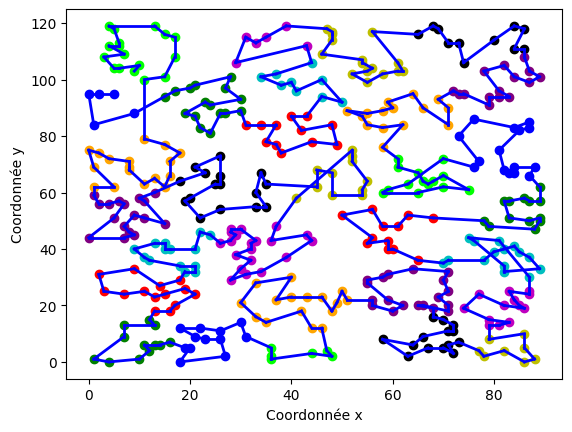

In [124]:
score3, k3, chemin3, groupe, temps3 = solver('./Pb3.txt')
print('Pour Pb3.txt - Meilleur score :', score3, 'avec K=', k3)
plot_chemin(chemin3, groupe)

resultat pour 60 clusters :  5437.273840539684
Pour Pb4.txt - Meilleur score : 5437.273840539684 avec K= 60


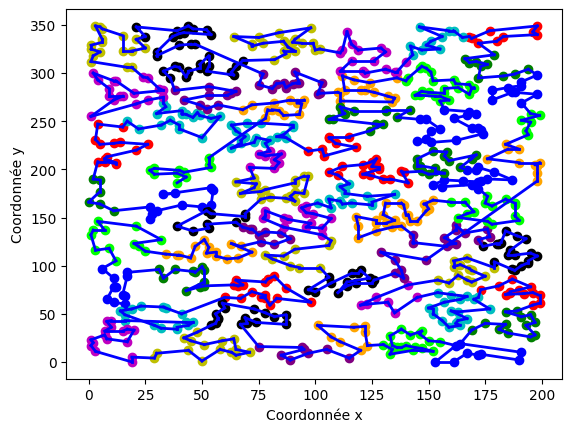

In [126]:
score4, k4, chemin4, groupe, temps4 = solver('./Pb4.txt')
print('Pour Pb4.txt - Meilleur score :', score4, 'avec K=', k4)
plot_chemin(chemin4, groupe)

resultat pour 80 clusters :  8691.565114057617
Pour Pb5.txt - Meilleur score : 8691.565114057617 avec K= 80


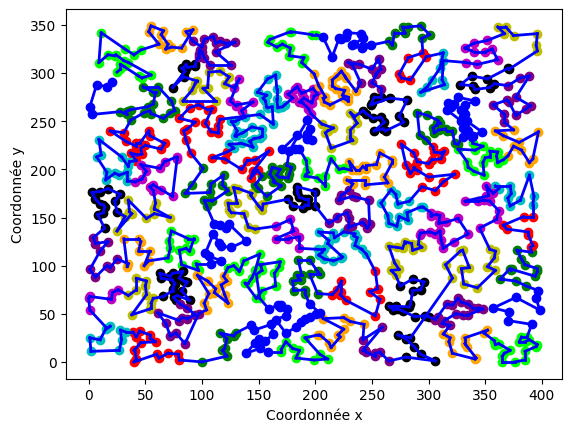

In [127]:
score5, k5, chemin5, groupe, temps = solver('./Pb5.txt')
print('Pour Pb5.txt - Meilleur score :', score5, 'avec K=', k5)
plot_chemin(chemin5, groupe)

In [128]:
Temps = [temps1, temps2, temps3, temps4, temps]
Score = [score1, score2, score3, score4, score5]
Pb = ["Pb1", "Pb2", "Pb3", "Pb4", "Pb5"]

In [129]:
import pandas as pd

data = {
    'Pb' : Pb,
    'Temps': Temps,
    'Score': Score
}
df = pd.DataFrame(data)
df.head()

,Pb,Temps,Score
0,Pb1,2.107289,240.236805
1,Pb2,21.804399,363.884945
2,Pb3,17.322607,1564.055181
3,Pb4,49.489039,5437.273841
4,Pb5,89.983146,8691.565114


# Remarque : pour  exécuter le fichier Traveling_Salesman_Problem.py, on rentre le chemin du fichier et l'algorithme nous renvoie la liste des index avec les permutations.